In [1]:
import numpy as np
import matplotlib.pyplot as plt
import miniramses as ram
import pyvista as pv
pv.set_jupyter_backend('trame')

In this notebook, we will explore a dataset produced by a cosmological galaxy formation simulation. Let's first download the data from the Tigress server here at Princeton University using the following command:

In [3]:
#!curl https://tigress-web.princeton.edu/~rt3504/DAT/carlos/output_00011.tar --output output_00011.tar
#!tar xvf output_00011.tar

We see that the data is stored in a folder called `output_00011` that contains many different files. The files we will use today are:
- the file containing the properties of the simulation `info.txt`
- the file containing the properties of the dark matter particles `part.00001`
- the file containing the properties of the clump `clump.00001`
- the file containing the properties of the gas `hydro.00001`

We will ignore the other files for now.

Let's first load up the general properties of the simulation.

In [5]:
info = ram.rd_info(11)
for prop in dir(info):
    if not prop.startswith("__"):
        print(f"{prop}: {getattr(info, prop)}")

H0: 67.7399978637695
aexp: 1.00001855951908
bound_key: [0. 0.]
boxlen: 1.0
gamma: 1.6666667
levelmin: 7
ncpu: 1
ndim: 3
nlevelmax: 18
omega_b: 0.0450000017881393
omega_k: 0.0
omega_l: 0.691100001335144
omega_m: 0.308899998664856
texp: 1.8582458112516e-05
time: 1.86684310488903e-05
unit_T2: 751674189.3226112
unit_d: 2.66466079514962e-30
unit_l: 1.13881560587217e+26
unit_t: 4.55534726271061e+17


For now, the imortant properties are `boxlen`, the size of the box in code units and `unit_l` the conversion factor to convert distances in code units in distances in physical units, here in centimeter. So we can get the size of the simulation box in centimeters using:

In [7]:
print("Box size in [cm]:",info.boxlen*info.unit_l)

Box size in [cm]: 1.13881560587217e+26


This is a big number! 1 followed by 26 zeros!

We can try and use different units. For example, in astrophysics, we like to use for distances light years. This is the distance traveled by a light ray moving at the speed of light during one full year. Let's compute this for fun.

The distance D is just the speed of light c in units of [cm per sec] times the number of seconds in a year.

$$D = c T$$

The speed of light is `c=3e+10`[cm/s] or 3 followed by 10 zeros. 

The number of seconds in a year is just `T=365*24*60*60=31536000`[s]. Can you explain why?

Now we can compute a light year in [cm] as:

In [10]:
speed_of_light=3e10
year_in_sec=365*24*60*60
light_year_in_cm=speed_of_light*year_in_sec
print("1 light year in [cm]:",light_year_in_cm)

1 light year in [cm]: 9.4608e+17


We can now compute our simulation box size in units of light year:

In [12]:
box_size_in_light_year = info.boxlen*info.unit_l/light_year_in_cm
print("Box size in light years:", box_size_in_light_year)

Box size in light years: 120372019.90023781


In other words, the simulation box size is close to 120 million light years.

Let's now load up the dark matter particles and have a look at their distribution.

In [14]:
part = ram.rd_part(11)
for prop in dir(part):
    if not prop.startswith("__"):
        print(f"{prop}: {getattr(part, prop)}")

Found 4230955 particles
idp: [1934471. 2033674. 1967111. ... 2124553. 2271189. 2241112.]
lp: [ 7.  7.  7. ... 18. 18. 18.]
mp: [4.07372369e-07 4.07372369e-07 4.07372369e-07 ... 7.95649158e-10
 7.95649158e-10 7.95649158e-10]
ndim: 3
np: 4230955
vp: [[-0.01496186 -0.01611082 -0.01921865 ... -0.04476263 -0.00736675
  -0.01110026]
 [-0.03194153 -0.04468822 -0.02862563 ...  0.03069192  0.02628956
   0.02808487]
 [ 0.04181155  0.04035892  0.04749037 ... -0.0408028  -0.02163131
  -0.03874045]]
xp: [[0.01605979 0.02219383 0.01054958 ... 0.51041675 0.51041949 0.51040596]
 [0.00838974 0.01561987 0.00732111 ... 0.60636669 0.60637045 0.60637897]
 [0.00419142 0.03099831 0.03108095 ... 0.50222808 0.50220561 0.50222093]]


We see that particle properties have been read from the file `part.00001` and stored in the object `part`. The object contains many interesting properties, in particular the particle masses `part.mp` and the particle positions `part.xp`.

Let's now plot the particles using their coordinates in space `x=part.xp[0]`, `y=part.xp[1]` and `z=part.xp[2]`. 

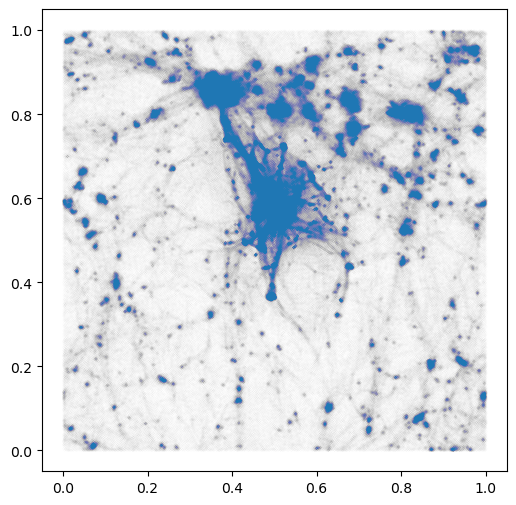

In [16]:
plt.figure(figsize=(6,6))
plt.scatter(part.xp[0],part.xp[1],s=0.00001)

We can see the typical distribution of dark matter on large scale in the Universe, with filaments of matter interconnected in what we call the Cosmic Web. At the intersection of filaments are dark matter halos, clumps of dark matter in which we believe galaxies like our own Milky Way do form. 

In order to explore this dataset more closely, let's use the 3D rendering tool `pyvista`. Using your mouse, rotate the view, zoom in, zoom out and develop a feeling of what we have here.

In [18]:
pc = pv.PolyData(np.column_stack((part.xp[0],part.xp[1],part.xp[2])))
pl = pv.Plotter(window_size=[500, 500])
pl.add_points(pc, style="points_gaussian", color="black", point_size=0.125, opacity=0.1)
pl.add_bounding_box()
pl.show()

Widget(value='<iframe src="http://localhost:53968/index.html?ui=P_0x32274f690_0&reconnect=auto" class="pyvista…

We see an interesting filamentary strucure at the center of the box, where we have obviously much more details. This is indeed a particular region where a dark matter halo similar to the Milky Way halo has formed in the simulation. To obtain an exact location for this dark matter halo, we will use the `clump.00001` file which contains the halo catalog of the simulation.

In the next cell, we read the halo catalog and select the halo that contains the largest number of particles. We store the exact position of this halo in the python variable `halo_center`. 

In [20]:
clump = ram.rd_clump(11)
ind = np.argmax(clump.npart)
halo_center = [clump.x[ind],clump.y[ind],clump.z[ind]]
print("Position of most massive clump:",halo_center )

Found 421 clumps
Position of most massive clump: [0.5029506683, 0.5873317719, 0.4994716644]


Now we can re-load the dark matter particles, but only within the halo region. Before we do this, we need to learn about the size of the Milky Way halo. From various astronomical observations, we know that the Milky Way dark matter halo is roughly spherical with a diameter of 2 million light years. We need to convert the corresponding radius $R$ from physical units back to code units. We get:

In [22]:
halo_radius = 1e6 * light_year_in_cm / info.unit_l
print("Halo radius in code units:", halo_radius)

Halo radius in code units: 0.00830757846240997


We will now read only the dark matter particle inside the halo. For this, we select a sphere of center `halo_center` and of radius `halo_radius`. We will have significantly less particles than before.

In [24]:
part_zoom = ram.rd_part(11,center=halo_center,radius=halo_radius)

Found 4230955 particles
Kept 725483 particles


Let's use again `pyvista` to visualize the dark matter particles in the halo.

In [26]:
pc = pv.PolyData(np.column_stack((part_zoom.xp[0],part_zoom.xp[1],part_zoom.xp[2])))
pl = pv.Plotter(window_size=[500, 500])
pl.add_points(pc, style="points_gaussian", color="black", point_size=0.5, opacity=0.1)
pl.add_bounding_box()
pl.show()

Widget(value='<iframe src="http://localhost:53968/index.html?ui=P_0x322759c10_1&reconnect=auto" class="pyvista…

We see a roughly spherical particle distribution with small clumps that we called *sub-halos*. The Milky Way halo would look probably very similar *if we could see it*. We will now analyze normal matter (not dark matter). We traditionally call it *the gas* because normal matter in cosmology is mostly made of Hydrogen gas. For this, we use the function `rd_cell` and store the result in a python object we name `gas`.

In [28]:
gas = ram.rd_cell(11,center=halo_center,radius=halo_radius)
for prop in dir(gas):
    if not prop.startswith("__"):
        print(f"{prop}: {getattr(gas, prop)}")

ncpu=1 ndim=3 nlevelmax=18
Time= 1.8582458112516e-05
Reading grid data...
Found nvar=8
Reading hydro data...
Found 7862177 leaf cells
Extracting leaf cells...
dx: [4.88281250e-04 4.88281250e-04 4.88281250e-04 ... 3.81469727e-06
 3.81469727e-06 3.81469727e-06]
level: [10 10 10 ... 17 17 17]
ncell: 1220513
ndim: 3
nvar: 8
u: [[ 2.37790895e+00  1.75858724e+00  2.11208653e+00 ...  3.64554901e+01
   3.63996048e+01  3.56902428e+01]
 [ 1.64451953e-02 -9.69909423e-04 -1.96085358e-03 ...  7.77877540e-06
  -2.19121648e-04 -7.22194090e-04]
 [ 8.70259181e-02  6.30886108e-02  5.66933863e-02 ...  6.74703270e-02
   6.70593977e-02  6.56811669e-02]
 ...
 [ 2.47153424e-04  3.55432392e-04  3.18748556e-04 ...  1.91746134e-04
   1.91547268e-04  1.91063897e-04]
 [ 1.99999995e-05  1.99999995e-05  1.99999995e-05 ...  1.99999995e-05
   1.99999995e-05  1.99999995e-05]
 [ 9.88481879e-01  9.99509692e-01  9.99426425e-01 ...  9.51636493e-01
   9.51876998e-01  9.52025890e-01]]
x: [[0.49731445 0.49829102 0.49926758 .

We see that the object `gas` contains several interesting properties such as `x[0]`, `x[1]` and `x[2]` the gas cell positions, `dx` the cell size, `u[0]` the gas density, `u[1]`, `u[2]`, `u[3]` the gas velocity and `u[5]` the gas pressure. 

We will make an image of the projected gas density throughout the halo, using the following command.

In [30]:
image = ram.mk_image(gas.x[0],gas.x[1],gas.dx,gas.u[0]**2*gas.dx)/ram.mk_image(gas.x[0],gas.x[1],gas.dx,gas.u[0]*gas.dx)

Making image of size:  4352 4352
Making image of size:  4352 4352


/var/folders/g3/_y51r9bs2_7c_tlffc2ztfcr0000gn/T/ipykernel_42117/2824201251.py:1: RuntimeWarning: invalid value encountered in divide
  image = ram.mk_image(gas.x[0],gas.x[1],gas.dx,gas.u[0]**2*gas.dx)/ram.mk_image(gas.x[0],gas.x[1],gas.dx,gas.u[0]*gas.dx)


Don't worry about the error message. We get an image that we will visualize using the `matplotlib` function `imshow`.

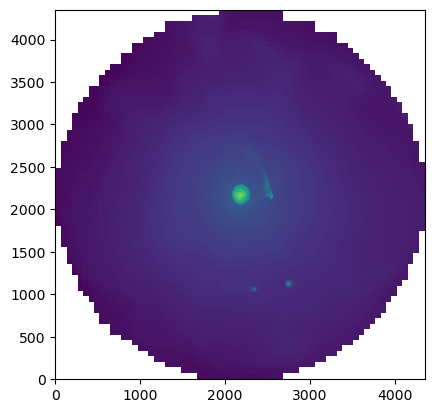

In [32]:
plt.imshow(np.log10(image),origin="lower")

The Hydrogen gas distribution is very different that the dark matter distribution. It is very smooth and regular, with a dense clump in the center, which is the galaxy at the center of the halo, like our own Milky Way, and a few orbiting smaller clumps around it, which we call *satellite galaxies*, like our own Large Magellanic Cloud and our own Small Magellanic Cloud. 

We are now going to zoom more into the central galaxy. For this, we will re-load the gas cells, reducing the sphere radius by a factor of 8.

In [34]:
gas = ram.rd_cell(11,center=halo_center,radius=halo_radius/8)

ncpu=1 ndim=3 nlevelmax=18
Time= 1.8582458112516e-05
Reading grid data...
Found nvar=8
Reading hydro data...
Found 7862177 leaf cells
Extracting leaf cells...


We create a small data cube that contains only the gas density in this small central region.

In [36]:
data = ram.mk_cube(gas.x[0],gas.x[1],gas.x[2],gas.dx,gas.u[0])

Making cube of size:  544 544 544


We finally visualize this region using a 3D rendering tool. Try and rotate the view, zoom in and zoom out. What do you see? 

In [38]:
grid = pv.ImageData()
grid.dimensions = np.array(data.shape) + 1
grid.cell_data["values"] = np.log10(data.flatten(order="F")+1e2)
pl = pv.Plotter(window_size=[500, 500])
pl.add_volume(grid, scalars="values", cmap="jet", opacity="sigmoid")
pl.add_bounding_box()
pl.show()

Widget(value='<iframe src="http://localhost:53968/index.html?ui=P_0x339f57b50_2&reconnect=auto" class="pyvista…

We know that the Sun is located at 25000 light years from the center of the Milky Way. We also know the size of the box in the visualization tool above. Can you guess where the Sun would be in this digital twin of the Milky Way?